In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]='0'

os.environ["HF_HOME"]="~/codes/.cache/huggingface"

In [2]:
import torch
import random
import numpy as np

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
set_seeds(42)

In [3]:
import matplotlib.pyplot as plt
def show_images(images, scores, test_artist, train_artists):
    n: int = len(images)
    f = plt.figure(figsize=(16, 2))
    for i in range(n):
        # Debug, plot figure
        ax = f.add_subplot(1, n, i + 1)
        if i==0:
            pass
            ax.title.set_text(test_artist)
        else:
            ax.title.set_text(str(np.round(scores[i-1], 4))+'\n'+train_artists[i-1])
            ax.axis('off')
        if images[i]==None:
            pass
        else:
            plt.imshow(images[i])

    plt.show(block=True)

In [4]:
from datasets import load_dataset

In [6]:
import pickle

In [7]:
with open('../../data/indices/50000-0.5/idx-train.pkl', 'rb')  as handle:
    idx_train = pickle.load(handle)
len(idx_train)   

50000

In [1]:
from datasets import load_dataset

dataset = load_dataset(
    'cifar10',
    # args.dataset_config_name,
    # cache_dir=args.cache_dir,
    # split="train",
)

NameError: name 'load_dataset' is not defined

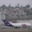

In [10]:
from datasets import DatasetDict, Dataset, load_dataset, Image

train_dataset = dataset['train'].select(idx_train)
train_dataset[0]["img"]

In [11]:
import pandas as pd
df = pd.DataFrame()
df['path'] = ['{}/{}.png'.format('../../saved/50000-0.5/gen', i) for i in range(1000)]

from datasets import DatasetDict, Dataset, load_dataset, Image
dataset = DatasetDict({
"train": Dataset.from_dict({
    "img": df['path'].tolist(),
}).cast_column("img", Image()),})
val_dataset = dataset["train"]

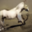

In [12]:
val_dataset[0]['img']

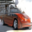

In [13]:
val_dataset[1]['img']

In [14]:
# val_dataset =  dataset['test'].select(idx_val)
# val_dataset[0]["img"]

In [15]:
# idx_val[0:5]

In [16]:
class Args():
            
    dataset_name="cifar10"

    output_dir="../../saved/50000-0.5/ddpm/checkpoint-78200"
    
    K=10
    # project_dim=3584
    Z=65536

    # used_dim=4096
    # used_dim=16384
    used_dim=32768
    
    t_strategy='uniform'
    
    # f='mean_squared_l2_norm'
    # f='l2_norm'
    # f='loss'
   
args = Args()

In [17]:
import diffusers
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.optimization import get_scheduler

In [18]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e3, eps=0.15)

2728

In [19]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=2e3, eps=0.15)

3002

In [20]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=5e3, eps=0.15)

3364

In [21]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim
johnson_lindenstrauss_min_dim(n_samples=1e4, eps=0.15)

3638

In [22]:
# load ground truth
my_list = [
    0,1,2,3,
    4,5,6,7,
    8,9,10,11,
    12,13,14,15,
    16,17,18,19,
    20,21,22,23,
    24,25,26,27,
    28,29,30,31,
    32,33,34,35,
    36,37,38,39,
    40,41,42,43,
    44,45,46,47,
    48,49,50,51,
    52,53,54,55,
    56,57,58,59,
    60,61,62,63,
          ]

In [23]:
loss_array_list = []

for i in my_list:
    for seed in [
        0,
                 1,
                 2,
                 # 3,
                 # 4,
                ]:
        for e_seed in [
            0, 
                       1, 
                       2
                      ]:
            with open('../../saved/50000-0.5/lds-val/ddpm-sub-{}-{}/e-{}-gen.pkl'.format(i, seed, e_seed), 'rb')  as handle:
                loss_list = pickle.load(handle)
            margins = np.concatenate(loss_list, axis=-1) # -logp
            ####
            if (seed==0) and (e_seed)==0:
                loss_array = margins
            else:
                loss_array += margins
            
    loss_array = loss_array/(3*3)
    
    loss_array_list.append(loss_array)
lds_loss_array = np.stack(loss_array_list)
lds_loss_array.shape

(64, 1000, 1000)

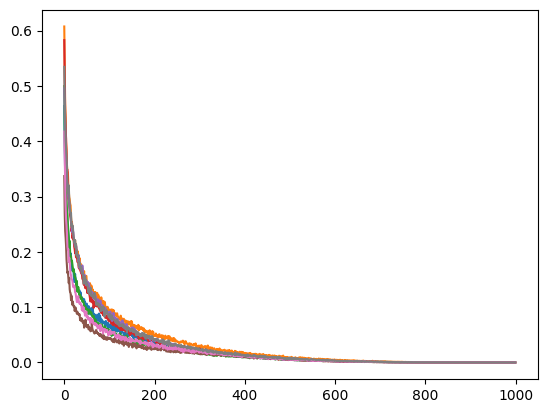

In [24]:
for i in range(1):
    for j in range(8):
        plt.plot(lds_loss_array[i, :, j], color="C{}".format(j))
    # break

In [25]:
mask_array_list = []

for i in my_list:
    # print(i)
    with open('../../data/indices/50000-0.5/lds-val/sub-idx-{}.pkl'.format(i), 'rb')  as handle:
        sub_idx_train = pickle.load(handle)
    # print(len(sub_idx_train))
    mask_array = np.in1d(idx_train, sub_idx_train)
        
    mask_array_list.append(mask_array)
    
lds_mask_array = np.stack(mask_array_list)
lds_mask_array.shape

(64, 50000)

In [26]:
lds_testset_correctness = lds_loss_array.mean(axis=1)
lds_testset_correctness.shape

(64, 1000)

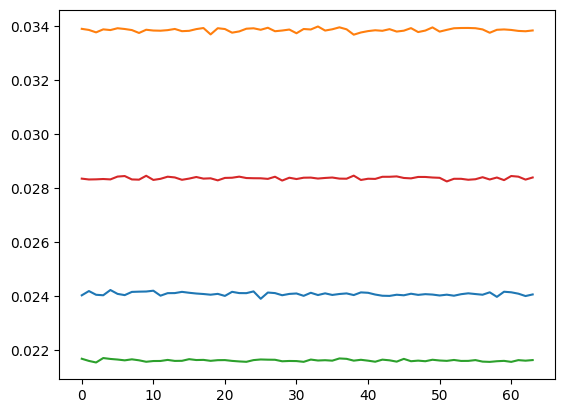

In [27]:
for j in range(4):
    plt.plot(lds_testset_correctness[:, j], color="C{}".format(j))
    # break
# plt.ylim(0.15, 0.2)

In [28]:
from scipy.stats import spearmanr, pearsonr

lamb_list = [
        # 0,

        1e-2, 2e-2, 5e-2,
        1e-1, 2e-1, 5e-1,
        1e0, 2e0, 5e0,
        1e1, 2e1, 5e1,
        1e2, 2e2, 5e2,
        1e3, 2e3, 5e3, 
        1e4, 2e4, 5e4, 
        1e5, 2e5, 5e5, 
        1e6, 2e6, 5e6, 
    
        # 1e7, 2e7, 5e7,
        # 1e8, 2e8, 5e8,
        # 1e9, 2e9, 5e9,
        # 1e10, 2e10, 5e10, 
        # 1e11, 2e11, 5e11,
        # 1e12
    ]

len(lamb_list)

27

In [29]:
# for loop over functions
lds_list = []
for K in [
    10, 
          100, 
          # 1000
         ]:
    ####
    ####
    dstore_keys_list = []
    for split in range(5):
        dstore_keys = np.memmap('{}/features-0/ddpm-train-keys-{}-{}-{}-{}-{}.npy'.format(
            args.output_dir, split, K, args.Z, 'mean-squared-l2-norm', args.t_strategy), 
                                dtype=np.float32, 
                                mode='r',
                                shape=(10000, args.Z))
        dstore_keys_list.append(dstore_keys) 
        
    dstore_keys = np.vstack(dstore_keys_list)
    print(dstore_keys.shape)  
    dstore_keys = dstore_keys[:, :args.used_dim]
    print(dstore_keys.shape)
    ####        
    gen_dstore_keys = np.memmap('{}/features-0/ddpm-gen-keys-{}-{}-{}-{}-{}.npy'.format(
                args.output_dir, 0, K, args.Z, 'mean-squared-l2-norm', args.t_strategy), 
                                dtype=np.float32, 
                                mode='r',
                                shape=(1000, args.Z))
    print(gen_dstore_keys.shape)    
    gen_dstore_keys = gen_dstore_keys[:, :args.used_dim]
    print(gen_dstore_keys.shape)
    ####
    dstore_keys = torch.from_numpy(dstore_keys).cuda()
    gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()
    # dstore_keys = torch.from_numpy(dstore_keys).cuda() * 1000
    # gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda() * 1000
    ####
    kernel = dstore_keys.T@dstore_keys
    ####
    rs_list = []
    ps_list = []

    best_scores = None
    best_lds = -np.inf
    for lamb in lamb_list:
        print(lamb)
        # kernel_ = kernel + lamb*np.eye(kernel.shape[0])
        kernel_ = kernel + lamb*torch.eye(kernel.shape[0]).cuda()
        # kernel_ = torch.from_numpy(kernel_).cuda()
        ####
        kernel_ = torch.linalg.inv(kernel_)  
        # kernel_ = kernel_.cpu().numpy()
        ####
        print(kernel_.shape)
        print(torch.mean(kernel_.diagonal()))
        ####
        # scores = gen_dstore_keys.dot((dstore_keys@kernel_).T)
        scores = gen_dstore_keys@((dstore_keys@kernel_).T)
        print(scores.size())
        scores = scores.cpu().numpy()
        
        # compute lds

        margins = lds_testset_correctness
        infl_est_ = -scores
        preds = lds_mask_array @ infl_est_.T
####
        rs = []
        ps = []

        for ind in range(1000):
           r, p = spearmanr(preds[:, ind], margins[:, ind])
           # r, p = pearsonr(preds[:, ind], margins[:, ind])
           rs.append(r)
           ps.append(p)
    
        rs, ps = np.array(rs), np.array(ps)
        print(f'Correlation: {rs.mean():.3f} (avg p value {ps.mean():.6f})')

        rs_list.append(rs.mean())   
        ps_list.append(ps.mean())

        if rs.mean()>best_lds:
            best_scores = scores
            best_lds = rs.mean()
            
    with open('./gen_5000_0.5_{}_{}_{}_{}.pkl'.format('mean-squared-l2-norm', K, lamb, best_lds), 'wb') as handle:
        pickle.dump(best_scores, handle)
            
    lds_list.append((rs_list, ps_list))

    # break

(50000, 65536)
(50000, 32768)
(1000, 65536)
(1000, 32768)


/tmp/ipykernel_3356/2286212090.py:34: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  gen_dstore_keys = torch.from_numpy(gen_dstore_keys).cuda()


0.01
torch.Size([32768, 32768])
tensor(0.0022, device='cuda:0')
torch.Size([1000, 50000])
Correlation: 0.004 (avg p value 0.503179)
0.02
torch.Size([32768, 32768])
tensor(0.0023, device='cuda:0')
torch.Size([1000, 50000])
Correlation: -0.000 (avg p value 0.509236)
0.05
torch.Size([32768, 32768])
tensor(0.0023, device='cuda:0')
torch.Size([1000, 50000])
Correlation: 0.001 (avg p value 0.484085)
0.1
torch.Size([32768, 32768])
tensor(0.0021, device='cuda:0')
torch.Size([1000, 50000])
Correlation: 0.004 (avg p value 0.488198)
0.2
torch.Size([32768, 32768])
tensor(0.0020, device='cuda:0')
torch.Size([1000, 50000])
Correlation: 0.002 (avg p value 0.504467)
0.5
torch.Size([32768, 32768])
tensor(0.0020, device='cuda:0')
torch.Size([1000, 50000])
Correlation: 0.002 (avg p value 0.506814)
1.0
torch.Size([32768, 32768])
tensor(0.0024, device='cuda:0')
torch.Size([1000, 50000])
Correlation: -0.001 (avg p value 0.502962)
2.0
torch.Size([32768, 32768])
tensor(0.0021, device='cuda:0')
torch.Size([100

In [30]:
lds_array = np.array(lds_list)
lds_array[0]

array([[ 3.67675956e-03, -4.25813641e-05,  7.32022325e-04,
         4.20757796e-03,  1.82586622e-03,  1.66346708e-03,
        -5.65785507e-04, -3.48182413e-03,  1.13512233e-03,
         2.30858960e-03, -8.31908802e-03,  3.17286643e-03,
         3.50208542e-03,  3.11495169e-03,  1.09648815e-03,
         3.53567577e-03,  9.12752827e-02,  1.12110706e-01,
         1.08967161e-01,  1.04058827e-01,  9.40096954e-02,
         8.50618928e-02,  7.69990030e-02,  6.72275532e-02,
         5.99966221e-02,  5.44812399e-02,  4.63280988e-02],
       [ 5.03179080e-01,  5.09236315e-01,  4.84084983e-01,
         4.88198393e-01,  5.04467378e-01,  5.06814127e-01,
         5.02961763e-01,  4.90552517e-01,  4.91682780e-01,
         4.99190209e-01,  5.08045781e-01,  5.01412387e-01,
         5.06984462e-01,  5.19877329e-01,  4.98218719e-01,
         4.92899499e-01,  4.23851604e-01,  3.84825267e-01,
         3.85123920e-01,  3.90312215e-01,  4.08118845e-01,
         4.19340175e-01,  4.37143608e-01,  4.54311854e-

In [31]:
lds_array.shape

(2, 2, 27)

In [32]:
with open('./gen_5000_0.5_{}.pkl'.format('mean-squared-l2-norm'), 'wb') as handle:
    pickle.dump(lds_array, handle)

In [33]:
lds_array[:, 0].max(axis=-1)

array([0.11211071, 0.16347542])

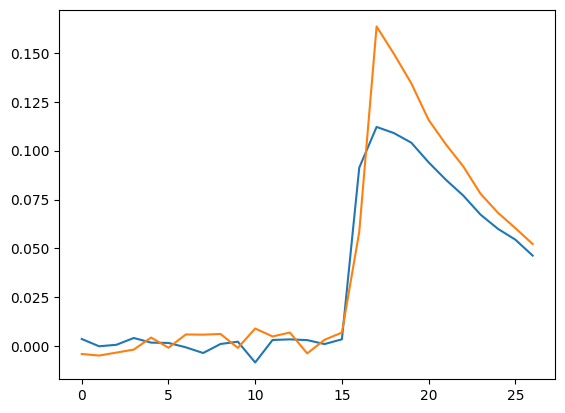

In [34]:
for k in range(lds_array.shape[0]):
    plt.plot(lds_array[k, 0])